## Unsupervised Learning Natural Language Processing Capstone 
In this unsupervised learning capstone, I use 24 novels from 12 authors from the NLTK Gutenberg corpus and [Project Gutenberg](https://www.gutenberg.org/) (which were manually addded to the corpus). 


Steps and techniques:
-  Pick a set of texts. I used 24 different texts from different authors on Project Gutenberg.
-  Perform standard data cleaning on the text using things such as spacy and stopwords.
-  Break the data in to two groups, the training group (75%) and the holdout group(25%).
-  Perform various clustering methods, decide which technique best represents the data, and explain your reasoning.
-  Perform some unsupervised feature generation and selection using techniques such as Latent Semantics Analysis (LSA), tf-idf term-document matrix, word2vec packaging, Latent Dirichlet Allocation (LDA) and Non-negative Matrix Factorization (NMF). 
-  Perform the clustering techniques on the holdout group and document the performance for changes, stability, and consistencies in comparison to the original model.
- Summarize all findings including visuals in a separate but linked document.

##### Imported Modules Cell

In [1]:
import numpy as np
import pandas as pd
import scipy
import spacy
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import requests
import pickle
import string
import en_core_web_sm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

#sklearn modules
import sklearn
from sklearn import ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
from sklearn import ensemble
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer, normalize
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline

#clustering
from sklearn.cluster import MeanShift, estimate_bandwidth, KMeans
from sklearn.cluster import SpectralClustering, AgglomerativeClustering, AffinityPropagation 
from sklearn.datasets.samples_generator import make_blobs
from sklearn import metrics
from sklearn.metrics import silhouette_score
import itertools
from itertools import cycle
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity


#nltk modules
import nltk
from nltk.corpus import gutenberg
from nltk.stem import WordNetLemmatizer 










### Data
- Emma by Jane Austen
- Sense and Sensibility by Jane Austen
- Alice's Adventures in Wonderland by Lewis Carroll
- Through the Looking Glass by Lewis Carroll
- A Christmas Carol by Charles Dickens
- David Copperfield by Charles Dickens 
- The Tragedie of Hamlet by William Shakespeare
- The Tragedie of Macbeth by William Shakespeare 
- Adventures Of Huckleberry Finn By Mark Twain 
- The Adventures of Tom Sawyer by Mark Twain



In [2]:
#Load the data/novels/text

data = {'author' :[ 'austen_emma', 'austen_sense', 'carroll_alice', 'carroll_glass', 
                   'dickens_christmas', 'dickens_copperfield', 'shakespeare_hamlet', 
                   'shakespeare_macbeth','twain_huckleberry', 'twain_sawyer'],
       'novel':[gutenberg.raw('austen-emma.txt'), gutenberg.raw('austen-sense.txt'), 
                gutenberg.raw('carroll-alice.txt'), gutenberg.raw('carroll-glass.txt'), 
                gutenberg.raw('dickens-christmas.txt'), gutenberg.raw('dickens-copperfield.txt'),   
                gutenberg.raw('shakespeare-hamlet.txt'), gutenberg.raw('shakespeare-macbeth.txt'), 
                gutenberg.raw('twain-huckleberry.txt'), gutenberg.raw('twain-sawyer.txt')]}

In [3]:
#place the data in a dataframe
books = pd.DataFrame(data)
books.head()

,author,novel
0,austen_emma,ï»¿Emma by Jane Austen 1816\n\nVOLUME I\n\nCHA...
1,austen_sense,ï»¿Sense and Sensibility by Jane Austen 1811\n...
2,carroll_alice,ï»¿[Alice's Adventures in Wonderland by Lewis ...
3,carroll_glass,ï»¿THROUGH THE LOOKING-GLASS\r\n\r\nBy Lewis C...
4,dickens_christmas,ï»¿A CHRISTMAS CAROL\r\n\r\nBy CHARLES DICKENS...


## Data Cleaning

In [4]:
# Utility function for standard text cleaning.
def text_cleaner(text):
   #change Mr. Mrs. Ms. St. etc. to another value for future sentence creation
    text = re.sub('Mrs\. ', 'Mrs0 ',text)
    text = re.sub('Mr\. ', 'Mr0 ', text)
    text = re.sub('St\. ', 'St0 ',text)
    text = re.sub('Ms\. ', 'Ms0 ',text)


    text = re.sub(r'--',' ',text)
    text = re.sub(r'_',' ',text)
    text = re.sub("[\[].*?[\]]", "", text)
    
    #get rid of chapter titles
    text = re.sub(r'Chapter \d+','',text)
    text = re.sub(r'CHAPTER \d+', '', text)
    
    #get rid of \n line breaks
    text = re.sub("\\n\\n.*?\\n\\n", '', text)
    
   #get rid of extra spacing and a random set of characters I saw
    text = re.sub("  ", " ",text)
    text = re.sub('[ï»¿]', '',text)
   
    
    text = ' '.join(text.split())
    return text
round0= lambda x: text_cleaner(x)

In [5]:
# Let's take a look at the updated text
books['novel'] = books.novel.apply(round0)

books.head(20)

,author,novel
0,austen_emma,Emma by Jane Austen 1816CHAPTER I Emma Woodhou...
1,austen_sense,Sense and Sensibility by Jane Austen 1811 The ...
2,carroll_alice,Alice was beginning to get very tired of sitti...
3,carroll_glass,THROUGH THE LOOKING-GLASS By Lewis Carroll The...
4,dickens_christmas,A CHRISTMAS CAROL By CHARLES DICKENS ILLUSTRAT...
5,dickens_copperfield,DAVID COPPERFIELD By Charles Dickens AFFECTION...
6,shakespeare_hamlet,Enter Barnardo and Francisco two Centinels. Ba...
7,shakespeare_macbeth,Thunder and Lightning. Enter three Witches. 1....
8,twain_huckleberry,ADVENTURES OF HUCKLEBERRY FINN (Tom Sawyer's C...
9,twain_sawyer,THE ADVENTURES OF TOM SAWYER By Mark Twain (Sa...


In [6]:
#turn text into sentences
sentences = []
for row in books.itertuples():
    for sentence in row[2].split('.'):
        if sentence != '':
            sentences.append((row[1], sentence))
books = pd.DataFrame(sentences, columns=['author', 'sentence'])

In [7]:
books.head(20)

,author,sentence
0,austen_emma,Emma by Jane Austen 1816CHAPTER I Emma Woodhou...
1,austen_emma,She was the youngest of the two daughters of ...
2,austen_emma,Her mother had died too long ago for her to h...
3,austen_emma,Sixteen years had Miss Taylor been in Mr0 Woo...
4,austen_emma,Between them it was more the intimacy of sisters
5,austen_emma,Even before Miss Taylor had ceased to hold th...
6,austen_emma,"The real evils, indeed, of Emma's situation w..."
7,austen_emma,"The danger, however, was at present so unperc..."
8,austen_emma,Sorrow came a gentle sorrow but not at all in...
9,austen_emma,Miss Taylor married


In [8]:
# Utility function for standard text cleaning.
def text_cleaner(text):

    #get rid of some punctuation and brackets
    text = re.sub("/.*? ", " ",text)
    text = re.sub("[\[].*?[\]]", "", text)
    text = re.sub("\\./\\.", "",text)
    text = re.sub("``", "",text)
    text = re.sub("''", "",text)
    text = re.sub("  ", " ",text)
    text = re.sub("./", " ",text)
    
    #just something I saw
    text = re.sub('1816CHAPTER', '', text)
    
    #change mr, mrs, ms, st, etc. back to their original format
    text = re.sub('Mr0 ', 'Mr. ', text)
    text = re.sub('Mrs0 ', 'Mrs. ',text)
    text = re.sub('St0 ', 'St. ',text)
    text = re.sub('Ms0 ', 'Ms. ',text)
    
    #get rid of extra spacing and a random set of characters I saw
    text = re.sub("  ", " ",text)
  
    text = re.sub("'s", " ",text)
    
    text = ' '.join(text.split())
    return text
round1= lambda x: text_cleaner(x)

In [9]:
# Let's take a look at the updated text
books['sentence'] = books.sentence.apply(round1)
books.head(20)

,author,sentence
0,austen_emma,"Emma by Jane Austen I Emma Woodhouse, handsome..."
1,austen_emma,She was the youngest of the two daughters of a...
2,austen_emma,Her mother had died too long ago for her to ha...
3,austen_emma,Sixteen years had Miss Taylor been in Mr. Wood...
4,austen_emma,Between them it was more the intimacy of sisters
5,austen_emma,Even before Miss Taylor had ceased to hold the...
6,austen_emma,"The real evils, indeed, of Emma situation were..."
7,austen_emma,"The danger, however, was at present so unperce..."
8,austen_emma,Sorrow came a gentle sorrow but not at all in ...
9,austen_emma,Miss Taylor married


In [10]:
#make sentences lowercase
books['sentence']= books['sentence'].str.lower()
books.head()

,author,sentence
0,austen_emma,"emma by jane austen i emma woodhouse, handsome..."
1,austen_emma,she was the youngest of the two daughters of a...
2,austen_emma,her mother had died too long ago for her to ha...
3,austen_emma,sixteen years had miss taylor been in mr. wood...
4,austen_emma,between them it was more the intimacy of sisters


In [11]:
books['tokenized_sents'] = books.apply(lambda row: nltk.word_tokenize(row['sentence']), axis=1)

In [12]:
books.head()

,author,sentence,tokenized_sents
0,austen_emma,"emma by jane austen i emma woodhouse, handsome...","[emma, by, jane, austen, i, emma, woodhouse, ,..."
1,austen_emma,she was the youngest of the two daughters of a...,"[she, was, the, youngest, of, the, two, daught..."
2,austen_emma,her mother had died too long ago for her to ha...,"[her, mother, had, died, too, long, ago, for, ..."
3,austen_emma,sixteen years had miss taylor been in mr. wood...,"[sixteen, years, had, miss, taylor, been, in, ..."
4,austen_emma,between them it was more the intimacy of sisters,"[between, them, it, was, more, the, intimacy, ..."


In [13]:
train_test, holdout= train_test_split(books, test_size=0.25)
train, test= train_test_split(train_test, test_size=0.30)

print('Train:', train.shape[0])
print('Test:', test.shape[0]) 
print('Holdout:', holdout.shape[0])

Train: 22117
Test: 9479
Holdout: 10533


In [14]:
vectorizer = TfidfVectorizer(max_df=0.6, min_df=2,
                            lowercase=True, use_idf=True,
                            norm='l2', stop_words='english',
                            smooth_idf=True)

# Applying the vectorizer
TfIdf = vectorizer.fit_transform(train['sentence'])

TfIdf_csr = TfIdf.tocsr()

In [15]:
#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,TfIdf_csr.shape[0])]

# List of features
terms = vectorizer.get_feature_names()
#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*TfIdf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = TfIdf_csr[i, j]

#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
print('Sentence:\n', books['sentence'][5],  '\nTf_idf vector:\n', tfidf_bypara[5])

Sentence:
 even before miss taylor had ceased to hold the nominal office of governess, the mildness of her temper had hardly allowed her to impose any restraint; and the shadow of authority being now long passed away, they had been living together as friend and friend very mutually attached, and emma doing just what she liked; highly esteeming miss taylor judgment, but directed chiefly by her own 
Tf_idf vector:
 {'keeps': 0.785421805928445, 'office': 0.6189608927647205}


## LSA

The percentage of total variance in the dataset explained by each component from LSA.
 [0.00528238 0.0044758  0.00451639 0.00370631 0.00328888]
Percent variance captured by all components: 29.624709320072128


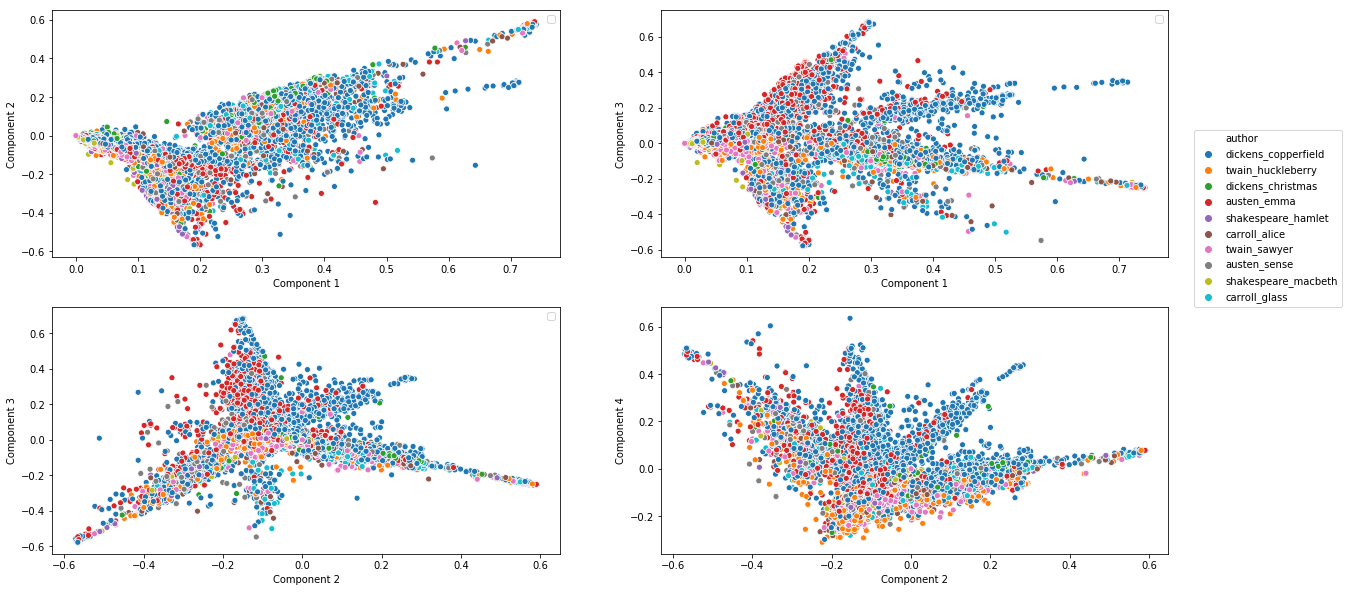

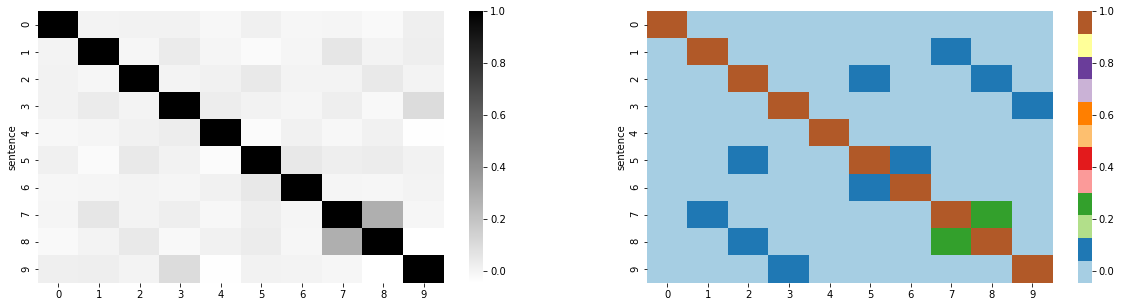

Key:
0 â if peggotty were looking for a hole, all of a sudden, in the heel of that stocking, it must have been a very little one indeed, and not worth darning
1 â so i got a piece of paper and a pencil, all glad and excited, and set down and wrote: miss watson, your runaway nigger jim is down here two mile below pikesville, and mr. phelps has got him and he will give him up for the reward if you send
2 "left it to his company, perhaps
3 the lane made a slight bend; and when that bend was passed, mr. elton was immediately in sight; and so near as to give emma time only to say farther, "ah! harriet, here comes a very sudden trial of our stability in good thoughts
4 we will try it
5 âhe keeps an office
6 scrooge looked about him for the ghost, and saw it not
7 â âwhy, are they after him yet?â âwell, you're innocent, ain't you! â does three hundred dollars lay around every day for people to pick up? â some folks think the nigger ain't far from here
8 by your account, he does se

In [16]:
#Our SVD data reducer. Features are reduced down to 250.
svd = TruncatedSVD(250)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
LSA = lsa.fit_transform(TfIdf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print(
    'The percentage of total variance in the dataset explained by each',
    'component from LSA.\n',
    variance_explained[:5]
)
print("Percent variance captured by all components:",total_variance*100)

# Compare the sklearn solution to ours – a perfect match.

plt.figure(figsize=(20,10))
for i, c in enumerate([(0,1), (0,2), (1,2), (1,3)]): 
    plt.subplot(2,2,i+1)
    sns.scatterplot(x=LSA[:, c[0]], y=LSA[:, c[1]], hue=train['author'])
    plt.legend('')
    plt.xlabel('Component ' + str(c[0]+1))
    plt.ylabel('Component ' + str(c[1]+1))
plt.legend(loc = (1.05, 1))
plt.show()



# Compute document similarity using LSA component
similarity = cosine_similarity(LSA)
#Only taking the first 10 sentences
sim_matrix=pd.DataFrame(similarity,index=train['sentence']).iloc[0:10,0:10]
#Making a plot
plt.figure(figsize=(20,5))
plt.subplot(121)
ax = sns.heatmap(sim_matrix,yticklabels=range(10), cmap='binary')
plt.subplot(122)
ax = sns.heatmap(sim_matrix,yticklabels=range(10), cmap='Paired')
plt.show()

#Generating a key for the plot.
print('Key:')
for i in range(10):
    print(i,sim_matrix.index[i])

#### Tfidf & LSA Summary

In [21]:
# Transform test set 
test_tfidf = vectorizer.transform(test['sentence'])
LSA_test = lsa.transform(test_tfidf)

# model vars
x_train = LSA
x_test = LSA_test
y_train = train['author']
y_test = test['author']

## Supervised Learning

### Logistic Regression

In [ ]:
lr = LogisticRegression()
lr.fit(x_train, y_train)

print('cross-validation:', cross_val_score(lr, x_train, y_train, cv=20))
print('Training set score:', lr.score(x_train, y_train))
print('Test set score:', lr.score(x_test, y_test))
pd.crosstab(y_test, lr.predict(x_test))

### Random Forest

In [ ]:

rfc = ensemble.RandomForestClassifier()
rfc.fit(x_train, y_train)

print('cross-validation:', cross_val_score(rfc, x_train, y_train, cv=20))
print('Training set score:', rfc.score(x_train, y_train))
print('Test set score:', rfc.score(x_test, y_test))
pd.crosstab(y_test, rfc.predict(x_test))

### Support Vector

In [ ]:
#support vector with CV

svc = SVC()
svc.fit(x_train, y_train)
print('cross-validation:', cross_val_score(svc, x_train, y_train, cv=20))
print('Training set score:', svc.score(x_train, y_train))
print('Test set score:', svc.score(x_test, y_test))
pd.crosstab(y_test, svc.predict(x_test))


### Gradient Boost Classifier

In [ ]:
#Gradient Boost
gbc = ensemble.GradientBoostingClassifier()
gbc.fit(x_train, y_train)
print('cross-validation:', cross_val_score(gbc, x_train, y_train, cv=20))
print('Training set score:', gbc.score(x_train, y_train))
print('Test set score:', gbc.score(x_test, y_test))
pd.crosstab(y_test, gbc.predict(x_test))


#### Supervised Learning Summary

In [17]:
n_clusters2 = 2
n_clusters5 = 5
n_clusters10 = 10

## Unsupervised Learning Methods

### K-Means

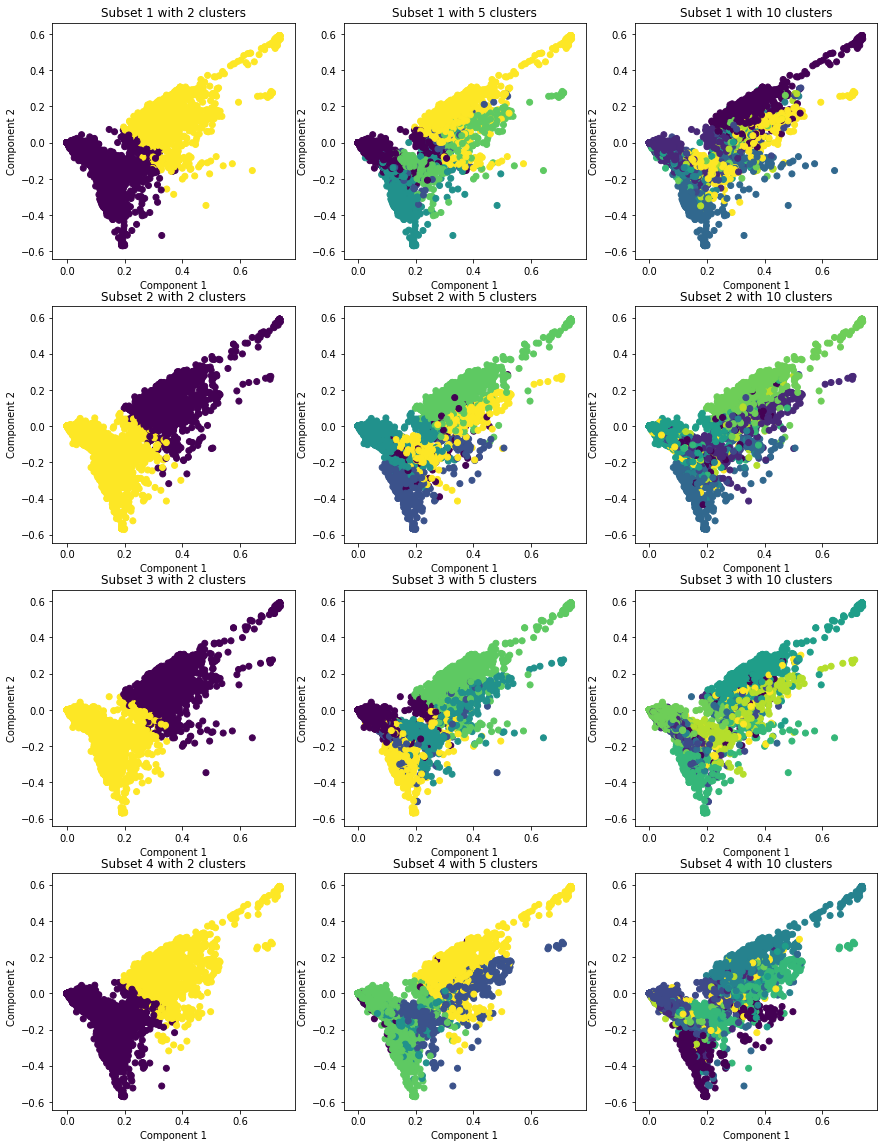

In [22]:
# Split the data to test for consistent clustering
lsa1, lsa3= train_test_split(LSA, test_size=0.50)
lsa1, lsa2= train_test_split(LSA, test_size=0.50)
lsa3, lsa4= train_test_split(LSA, test_size=0.50)

plt.figure(figsize=(20,20))
# Calculate predicted values.
preds = {}
models = {}
clusters = (2,5,10)

for row, data in enumerate([lsa1, lsa2, lsa3, lsa4, LSA]):
    
    # Generate cluster predictions and store them for clusters 2 to 4.
    for col, nclust in  enumerate(clusters):
        models[row, nclust] = KMeans(n_clusters=nclust, random_state=42).fit(data)
        preds[row, nclust] = models[row, nclust].predict(data)
        
        if row != 4:
            plt.subplot(4, 4, row*4 + (col+1))
            plt.scatter(data[:, 0], data[:, 1], c=preds[row, nclust])
            plt.title('Subset ' + str(row + 1) +' with ' + str(nclust) +' clusters')
            plt.xlabel('Component 1')
            plt.ylabel('Component 2')
        

In [23]:
# Function to evaluate the clustering
def cluster_eval(clusters, preds, models, n):
    for i in clusters: 
        pred = preds[4,i]
        model = models[4,i]
        labels = model.labels_
        print('Adjusted Rand index for', i, 'clusters:', 
              round(metrics.adjusted_rand_score(train['author'], pred),5))
        print('The silhouette coefficient for %d clusters: %.4f \n' % (i, metrics.silhouette_score(LSA, labels, metric='euclidean')))

    return(pd.crosstab(train['author'], preds[4,n]).T)

cluster_eval(clusters, preds, models, 10)

Adjusted Rand index for 2 clusters: -0.01436
The silhouette coefficient for 2 clusters: 0.0139 

Adjusted Rand index for 5 clusters: -0.034
The silhouette coefficient for 5 clusters: 0.0208 

Adjusted Rand index for 10 clusters: 0.00071
The silhouette coefficient for 10 clusters: 0.0306 



author,austen_emma,austen_sense,carroll_alice,carroll_glass,dickens_christmas,dickens_copperfield,shakespeare_hamlet,shakespeare_macbeth,twain_huckleberry,twain_sawyer
col_0,,,,,,,,,,
0,53,34,16,21,16,209,45,31,141,55
1,363,32,0,0,10,919,0,0,1,12
2,1052,910,17,43,56,715,48,24,112,114
3,110,77,25,44,15,312,25,11,73,49
4,1431,726,205,461,598,4298,723,441,1795,1447
5,105,107,111,173,91,740,3,2,137,115
6,138,99,25,23,22,184,25,16,56,49
7,11,10,17,33,11,130,2,2,279,82
8,109,77,24,33,25,238,18,17,113,82


In [24]:
km2 = KMeans(n_clusters=n_clusters2)
km2.fit(x_train)

train['clusterkm2'] = km2.labels_ 
print(pd.crosstab(train['author'], train['clusterkm2']), '\n')

clusterkm2              0     1
author                         
austen_emma           194  3422
austen_sense          169  1987
carroll_alice         149   291
carroll_glass         216   617
dickens_christmas     109   735
dickens_copperfield  1314  6741
shakespeare_hamlet      5   884
shakespeare_macbeth     2   542
twain_huckleberry     188  2545
twain_sawyer          145  1862 



In [25]:
#clusters - 5
km5 = KMeans(n_clusters=n_clusters5)
km5.fit(x_train)

train['clusterkm5'] = km5.labels_ 
print(pd.crosstab(train['author'], train['clusterkm5']), '\n')

clusterkm5             0     1     2     3    4
author                                         
austen_emma          161   471   122  2715  147
austen_sense          68    52    58  1827  151
carroll_alice         47     0    49   211  133
carroll_glass         60     0    81   490  202
dickens_christmas     32    11    51   648  102
dickens_copperfield  490  1013   503  5187  862
shakespeare_hamlet     5     0   666   214    4
shakespeare_macbeth    2     0   301   239    2
twain_huckleberry     73     2  1036  1443  179
twain_sawyer          71    13   614  1182  127 



In [26]:
km10 = KMeans(n_clusters=n_clusters10)
km10.fit(x_train)

train['clusterkm10'] = km10.labels_ 
print(pd.crosstab(train['author'], train['clusterkm10']), '\n')

clusterkm10             0    1    2     3    4    5    6    7    8    9
author                                                                 
austen_emma          1407  382  131   896  148  244  129   44  130  105
austen_sense         1154   35   99   438   69   85   84   29   62  101
carroll_alice          19    0   33   212    7    0   27   14    9  119
carroll_glass          32    0   45   467   16    2   52   15   29  175
dickens_christmas      85   10   39   497   30    0   15   18   62   88
dickens_copperfield  1170  973  283  3428  245  309  331  181  418  717
shakespeare_hamlet    150    0   49   338   36    0   27  260   26    3
shakespeare_macbeth    42    0   24   282   17    0   15  142   20    2
twain_huckleberry     101    1  120  1770  118   32   86  136  225  144
twain_sawyer          142   13   82  1396   38    2   58   56  103  117 



### Agglomerative clustering

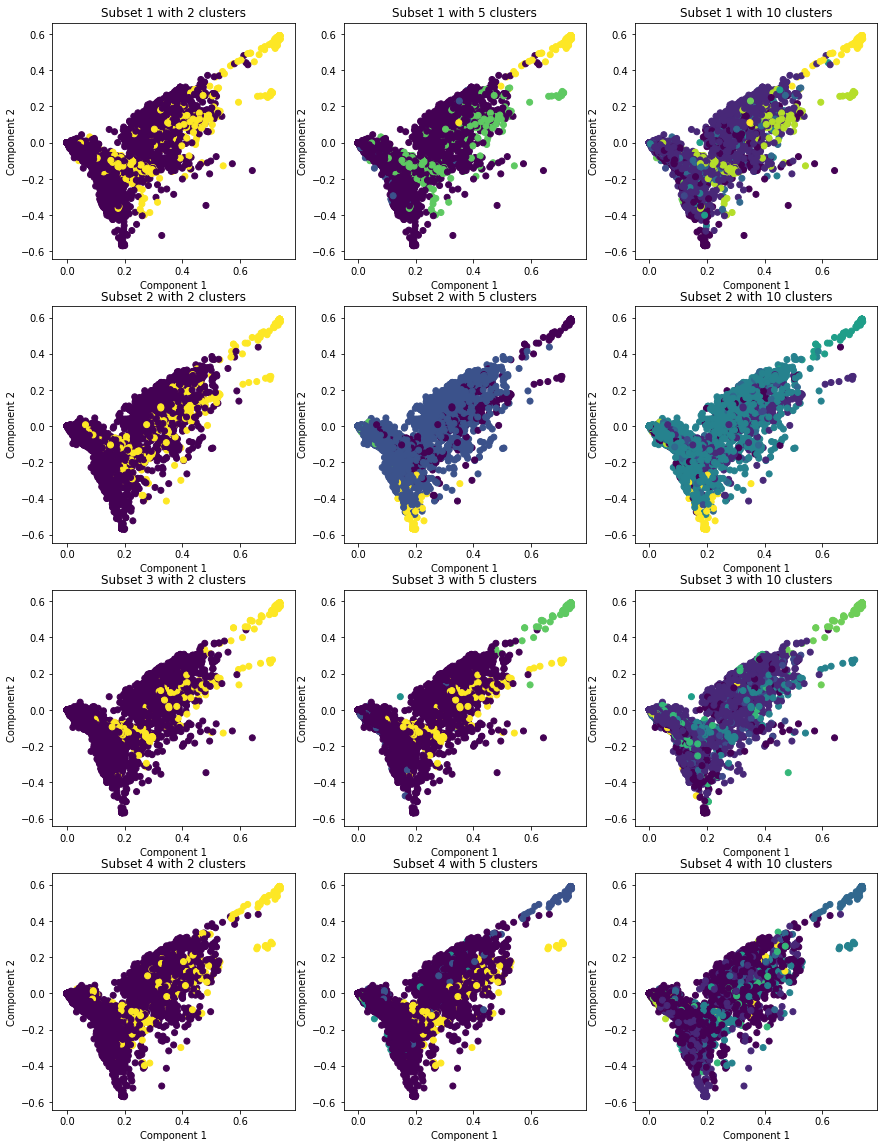

In [29]:
plt.figure(figsize=(20,20))
# Calculate predicted values.
preds_2 = {}
models_2 = {}
clusters = (2,5,10)
for row, data in enumerate([lsa1, lsa2, lsa3, lsa4, LSA]):
    
    # Generate cluster predictions and store them for clusters 2 to 4.
    for col, nclust in  enumerate(clusters):
        models_2[row, nclust] = AgglomerativeClustering(n_clusters=nclust).fit(data)
        preds_2[row, nclust] = AgglomerativeClustering(n_clusters=nclust).fit_predict(data)
        
        if row != 4:
            plt.subplot(4, 4, row*4 + (col+1))
            plt.scatter(data[:, 0], data[:, 1], c=preds_2[row, nclust])
            plt.title('Subset ' + str(row + 1) +' with ' + str(nclust) +' clusters')
            plt.xlabel('Component 1')
            plt.ylabel('Component 2')
        
plt.show()

### Spectral Clustering

In [ ]:
plt.figure(figsize=(20,20))
# Calculate predicted values.
preds = {}
models = {}
clusters = (2,5,10)
for row, data in enumerate([lsa1, lsa2, lsa3, lsa4, LSA]):
    
    # Generate cluster predictions and store them for clusters 2 to 4.
    for col, nclust in  enumerate(clusters):
        models_2[row, nclust] = SpectralClustering(n_clusters=nclust).fit(data)
        preds_2[row, nclust] = SpectralClustering(n_clusters=nclust).fit_predict(data)
        
        if row != 4:
            plt.subplot(4, 4, row*4 + (col+1))
            plt.scatter(data[:, 0], data[:, 1], c=preds_2[row, nclust])
            plt.title('Subset ' + str(row + 1) +' with ' + str(nclust) +' clusters')
            plt.xlabel('Component 1')
            plt.ylabel('Component 2')
        
plt.show()

In [ ]:
sc2 = SpectralClustering(n_clusters=n_clusters2, affinity='rbf')
sc2.fit(train_lsa)

train['clustersc2'] = sc2.labels_

print(pd.crosstab(train['author'], train['clustersc2']), '\n')

In [ ]:
#with 5 clusters
sc5 = SpectralClustering(n_clusters=n_clusters5, affinity='rbf')
sc5.fit(train_lsa)

train['clustersc5'] = sc5.labels_

print(pd.crosstab(train['author'], train['clustersc5']), '\n')

In [ ]:
#with 10 clusters

sc10 = SpectralClustering(n_clusters=n_clusters10, affinity='rbf')
sc10.fit(train_lsa)

train['clustersc10'] = sc10.labels_

print(pd.crosstab(train['author'], train['clustersc10']), '\n'))

### Affinity Propagation

In [ ]:
af = AffinityPropagation()
af.fit(train_lsa)

train['clusteraf'] = af.labels_

cluster_df = pd.crosstab(train['author'], train['clusteraf'])
cluster_df